# LSTM/SelfAttention
* Weekly data, normalized and not

# Imports

In [1]:
import os
import json
import random
import calendar
import datetime
import warnings
import logging
import numpy as np
import pandas as pd
from datetime import timedelta
from collections import Counter
from google.cloud import bigquery

from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets

warnings.filterwarnings("ignore")
tqdm.pandas()

In [2]:
import scipy.stats
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.get_logger().setLevel("ERROR")

from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm.keras import TqdmCallback

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Config

In [3]:
# Config
PROJECT_ID = "arpae-prod-ml"

# Dataset path
dataset_path = "data/"

# Ouput
model_output = "models"

## Methods

In [4]:
def _run_query(client, query):
    df = client.query(query).to_dataframe()
    return df

def _create_station_widget(df):
    station_ids = df.station_id.sort_values().unique()
    station_wdgt = widgets.Dropdown(options=station_ids, description='Station Id:', layout={"width":"50%"})
    return station_wdgt

def _create_pol_var_id_widget(df):
    pol_var_ids = df.pol_var_id.sort_values().unique()
    pol_wdgt = widgets.Dropdown(options=pol_var_ids, description='Pol var id:', layout={"width":"50%"})
    return pol_wdgt

def _create_cluster_n_widget(df):
    cluster_ids = list(df.cluster.sort_values().unique())
    cls_wdgt = widgets.Dropdown(options=cluster_ids, description='Cluster id:', layout={"width":"50%"})
    return cls_wdgt

def min_max_scale(x):
    return (x - x.min()) / (x.max() - x.min())

___

# 1. Load Dataset

### Load clustering results

In [5]:
### Load clustering data
# clusters = pd.read_csv("../data/clusters/clustering_tsd_intervals.csv")
clusters = pd.read_csv("data/clusters/clustering_intervals.csv")

print(clusters.shape)
display(clusters.sample(3))

# plt.figure(figsize=(8,2))
# plt.title("Number of specie/station per cluster")
# sns.countplot(x=clusters["cluster"]);

(363, 3)


,station_id,pol_var_id,cluster
144,6,B48017,1
192,7,B48037,9
354,13,B48033,1


### Load dataset

In [6]:
# bq_client = bigquery.Client.from_service_account_json("data/arpae-prod-ml-f7820c528250.json")

# sql = f"SELECT * FROM `{PROJECT_ID}.JOINED_DATA.SLIDING_WINDOWS_DATASET`"
# df_dataset = _run_query(bq_client, sql)

In [7]:
# Load dataset
df_dataset = pd.read_feather("data/dataset_7D_normalized_2023.feather")
df_dataset.drop_duplicates(inplace=True)

# Convert dates, sort and set index
df_dataset.date = pd.to_datetime(df_dataset.date)
df_dataset.sort_values(["station_id", "pol_var_id", "date"], inplace=True)
df_dataset.set_index("date", inplace=True)

In [8]:
### Dataset preview
print(df_dataset.shape)
df_dataset.head(5)

(1178889, 99)


,station_id,pol_var_id,B13011_min_amin,B13011_max_amax,B13011_mean_mean,B13011_std_mean,B13011_sum_sum,B14198_min_amin,B14198_max_amax,B14198_mean_mean,...,pol_var_id_B48034,pol_var_id_B48036,pol_var_id_B48037,pol_var_id_B48038,pol_var_id_B48039,pol_var_id_B48041,pol_var_id_B48044,pol_var_id_B48045,WHICH,cluster
date,,,,,,,,,,,,,,,,,,,,,
2006-09-05 00:00:00+00:00,1,B48001,0.0,0.010309,0.007163,0.010346,5.140287e-03,0.555556,0.707631,0.648377,...,0,0,0,0,0,0,0,0,training,3
2006-09-06 00:00:00+00:00,1,B48001,0.0,0.010309,0.001791,0.004397,1.285072e-03,0.555556,0.707631,0.644707,...,0,0,0,0,0,0,0,0,training,3
2006-09-07 00:00:00+00:00,1,B48001,0.0,0.000000,0.000000,0.000000,6.087323e-17,0.555556,0.684836,0.625042,...,0,0,0,0,0,0,0,0,training,3
2006-09-08 00:00:00+00:00,1,B48001,0.0,0.017182,0.015519,0.011157,1.113729e-02,0.555556,0.677899,0.585648,...,0,0,0,0,0,0,0,0,training,3
2006-09-09 00:00:00+00:00,1,B48001,0.0,0.044674,0.031038,0.037994,2.227458e-02,0.555556,0.679881,0.582157,...,0,0,0,0,0,0,0,0,training,3


___

# 2. Define training parameters

In [9]:
all_features = [
    # 'station_id', 'pol_var_id', 'pol_value_label',
    # 'season_label', 'seasonal_mean', 'seasonal_prev_1',
    # 'trend_label', 'trend_mean', 'trend_prev_1',
    # 'residual_label', 'residual_mean', 'residual_prev_1',
    'week_amax',
    'B13011_min_amin', 'B13011_max_amax', 'B13011_mean_mean', 'B13011_std_mean', 'B13011_sum_sum',
    'B14198_min_amin', 'B14198_max_amax', 'B14198_mean_mean', 'B14198_std_mean', 'B14198_sum_sum',
    #'TEMP_min_amin', 'TEMP_max_amax', 'TEMP_mean_mean', 'TEMP_std_mean', 'TEMP_sum_sum',
    'station_lat_amax', 'station_lon_amax', 'station_H_piano_strada_amax', 'station_H_mslm_amax',
    #'PREC_amin', 'PREC_mean', 'PREC_std', 'PREC_median', 'PREC_amax', 'PREC_skew', 'PREC_kurtosis',
    'pol_value_amin', 'pol_value_mean', 'pol_value_std', 'pol_value_median', 'pol_value_amax', 'pol_value_skew', 'pol_value_kurtosis',
    'pol_value_prev_1', 'pol_value_prev_2', 'pol_value_prev_3', 'pol_value_prev_4', 'pol_value_prev_5', 'pol_value_prev_6', 'pol_value_prev_7',
    'station_id_1', 'station_id_2', 'station_id_4', 'station_id_5', 'station_id_6', 'station_id_7', 'station_id_8', 'station_id_9', 'station_id_10', 'station_id_11', 'station_id_13',
    'pol_var_id_B48001', 'pol_var_id_B48002', 'pol_var_id_B48003', 'pol_var_id_B48005', 'pol_var_id_B48006', 'pol_var_id_B48007', 'pol_var_id_B48008', 'pol_var_id_B48011', 'pol_var_id_B48012', 'pol_var_id_B48013', 'pol_var_id_B48015', 'pol_var_id_B48016', 'pol_var_id_B48017', 'pol_var_id_B48018', 'pol_var_id_B48019', 'pol_var_id_B48021', 'pol_var_id_B48023', 'pol_var_id_B48024', 'pol_var_id_B48025', 'pol_var_id_B48026', 'pol_var_id_B48029', 'pol_var_id_B48030', 'pol_var_id_B48031', 'pol_var_id_B48032', 'pol_var_id_B48033', 'pol_var_id_B48034', 'pol_var_id_B48036', 'pol_var_id_B48037', 'pol_var_id_B48038', 'pol_var_id_B48039', 'pol_var_id_B48041', 'pol_var_id_B48044', 'pol_var_id_B48045'
]

y_label = "pol_value_label"

print(f"Len features: {len(all_features)}")
print(f"y_label: {y_label}")

Len features: 73
y_label: pol_value_label


In [10]:
def get_dataset(cluster_n, params):
    # Create an object to store dataset and results
    class dataset: pass
    dataset.cluster_n = cluster_n

    # Create cluster training/test/validation split
    df_feature = df_dataset[df_dataset.cluster == cluster_n].copy()
    dataset.x_train = df_feature[df_feature.WHICH == "training"]
    dataset.y_train = df_feature[df_feature.WHICH == "training"][[y_label]]
    dataset.x_valid = df_feature[df_feature.WHICH == "validation"]
    dataset.y_valid = df_feature[df_feature.WHICH == "validation"][[y_label]]
    dataset.x_test = df_feature[df_feature.WHICH == "test"]
    dataset.y_test = df_feature[df_feature.WHICH == "test"][[y_label]]
    
    # Drop all-0 columns (one hot encodings)
    to_keep = [c for c in dataset.x_train.columns if dataset.x_train[c].any()]
    dataset.features = [feature for feature in all_features if feature in to_keep]

    dataset.train_dataset = timeseries_dataset_from_array(dataset.x_train[dataset.features], dataset.y_train, sequence_length=params.sequence_length, batch_size=params.batch_size)
    dataset.valid_dataset = timeseries_dataset_from_array(dataset.x_valid[dataset.features], dataset.y_valid, sequence_length=params.sequence_length, batch_size=params.batch_size)
    dataset.test_dataset = timeseries_dataset_from_array(dataset.x_test[dataset.features], dataset.y_test, sequence_length=params.sequence_length, batch_size=params.batch_size)

    return dataset

___

# 3. Load Models
* LSTM + MultiHeadAttention
* Best parameters

In [11]:
# Model parameters
class model_params:
    lstm_1_units = 512
    lstm_2_units = 128
    dense_1_units = 256
    dense_2_units = 256
    dropout = .2
    learning_rate = 0.001
    batch_size = 1024
    sequence_length = 7
    n_epochs = 100
    patience = 10
    shuffle = True

In [12]:
model_name = "LSTM+MultiHeadAttention+AdamW"
model_paths = os.listdir(model_output)
model_paths = sorted(filter(lambda p: model_name in p and p.endswith(".h5"), model_paths))

In [13]:
trainings = []
for path in tqdm(model_paths):
    print(f"Loading model {path}")
    
    # Load dataset
    cluster_n = int(path.split("-")[-1].split(".")[0])
    dataset = get_dataset(cluster_n=cluster_n, params=model_params)

    # Load model and fit dataset
    dataset.model = tf.keras.models.load_model(os.path.join(model_output, path))
    
    trainings.append(dataset)

  0%|          | 0/10 [00:00<?, ?it/s]

Loading model LSTM+MultiHeadAttention+AdamW_Cluster-0.h5
Loading model LSTM+MultiHeadAttention+AdamW_Cluster-1.h5
Loading model LSTM+MultiHeadAttention+AdamW_Cluster-2.h5
Loading model LSTM+MultiHeadAttention+AdamW_Cluster-3.h5
Loading model LSTM+MultiHeadAttention+AdamW_Cluster-4.h5
Loading model LSTM+MultiHeadAttention+AdamW_Cluster-5.h5
Loading model LSTM+MultiHeadAttention+AdamW_Cluster-6.h5
Loading model LSTM+MultiHeadAttention+AdamW_Cluster-7.h5
Loading model LSTM+MultiHeadAttention+AdamW_Cluster-8.h5
Loading model LSTM+MultiHeadAttention+AdamW_Cluster-9.h5


In [20]:
### Store model features
model_features = {}
for dataset in trainings:
    model_features[dataset.cluster_n] = dataset.features

with open("data/model_features.json", "w") as outfile:
    outfile.write(json.dumps(model_features, indent=3))

___

# 4. Models MSE on Training / Validation / Test sets

Model: LSTM+MultiHeadAttention+AdamW


  0%|          | 0/10 [00:00<?, ?it/s]

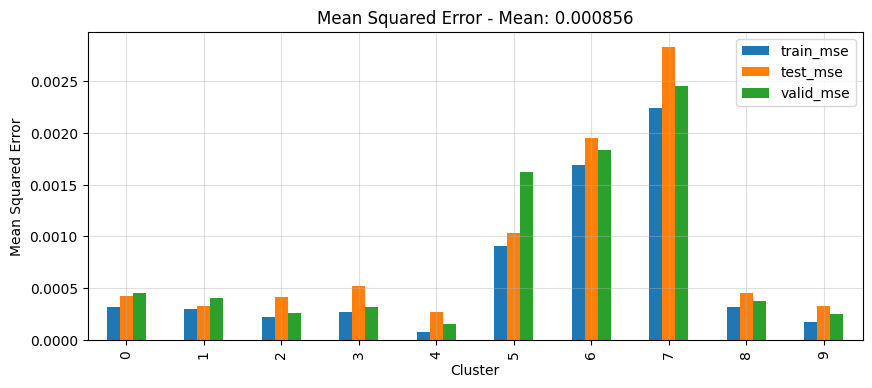

In [16]:
cluster_model_mse = []
print("Model:", model_name)
for dataset in tqdm(trainings):
    cluster_model_mse.append({
        "cluster_n": dataset.cluster_n,
        "train_mse": dataset.model.evaluate(dataset.train_dataset, verbose=False),
        "test_mse": dataset.model.evaluate(dataset.test_dataset, verbose=False),
        "valid_mse": dataset.model.evaluate(dataset.valid_dataset, verbose=False),
    })
cluster_model_mse = pd.DataFrame(cluster_model_mse)

fig, ax = plt.subplots(figsize=(10, 4))
cluster_model_mse.plot(x='cluster_n', kind='bar', ax=ax)
ax.set_title(F'Mean Squared Error - Mean: {cluster_model_mse.test_mse.mean().round(6)}')
ax.set_xlabel('Cluster')
ax.set_ylabel('Mean Squared Error')
plt.grid(alpha=.4)
plt.show()

___

# 5. Training/Validation Performance per cluster

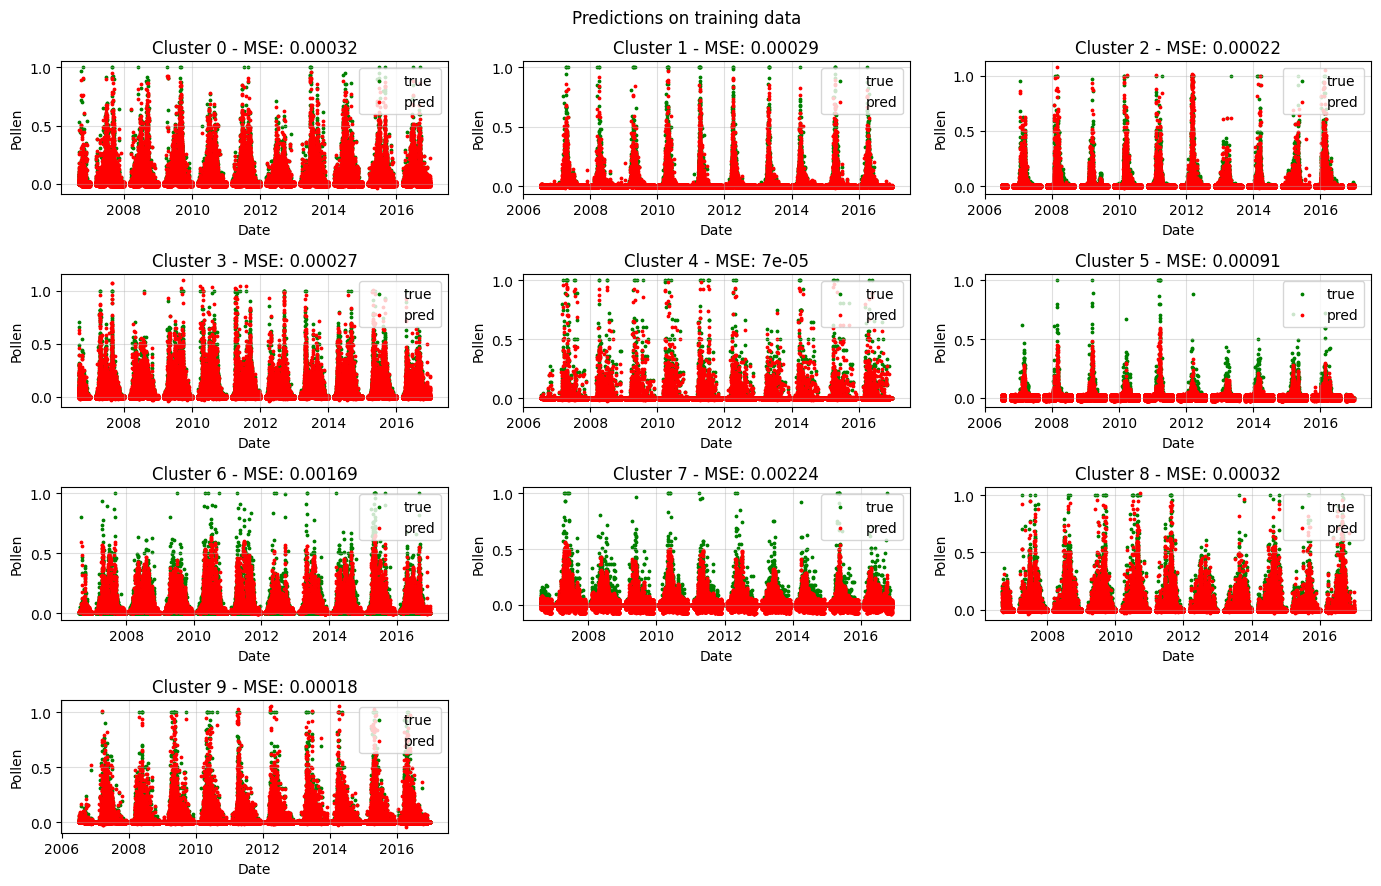

In [17]:
### Test on training data
rows, cols = 4, 3
fig, axs = plt.subplots(rows, cols, figsize=(14,9), squeeze=False)
plt.suptitle("Predictions on training data")
for subpltn, dataset in enumerate(trainings):
    predictions = dataset.model.predict(dataset.train_dataset, verbose=False).squeeze()
    mse = dataset.model.evaluate(dataset.train_dataset, verbose=False)
    ax = axs[divmod(subpltn, cols)]
    ax.set_title(f"Cluster {dataset.cluster_n} - MSE: {np.round(mse, 5)}")
    ax.scatter(dataset.y_train.index, dataset.y_train.values, s=3, c="green", label="true")
    ax.scatter(dataset.y_train.index[:-model_params.sequence_length+1], predictions, s=3, c="red", label="pred")
    ax.set_ylabel("Pollen")
    ax.set_xlabel("Date")
    ax.legend(loc="upper right")
    ax.grid(alpha=.4)

for subpltn in range(subpltn+1, rows*cols): fig.delaxes(axs.flatten()[subpltn]) # removing empty plots from subplot grid
plt.tight_layout()
plt.show();

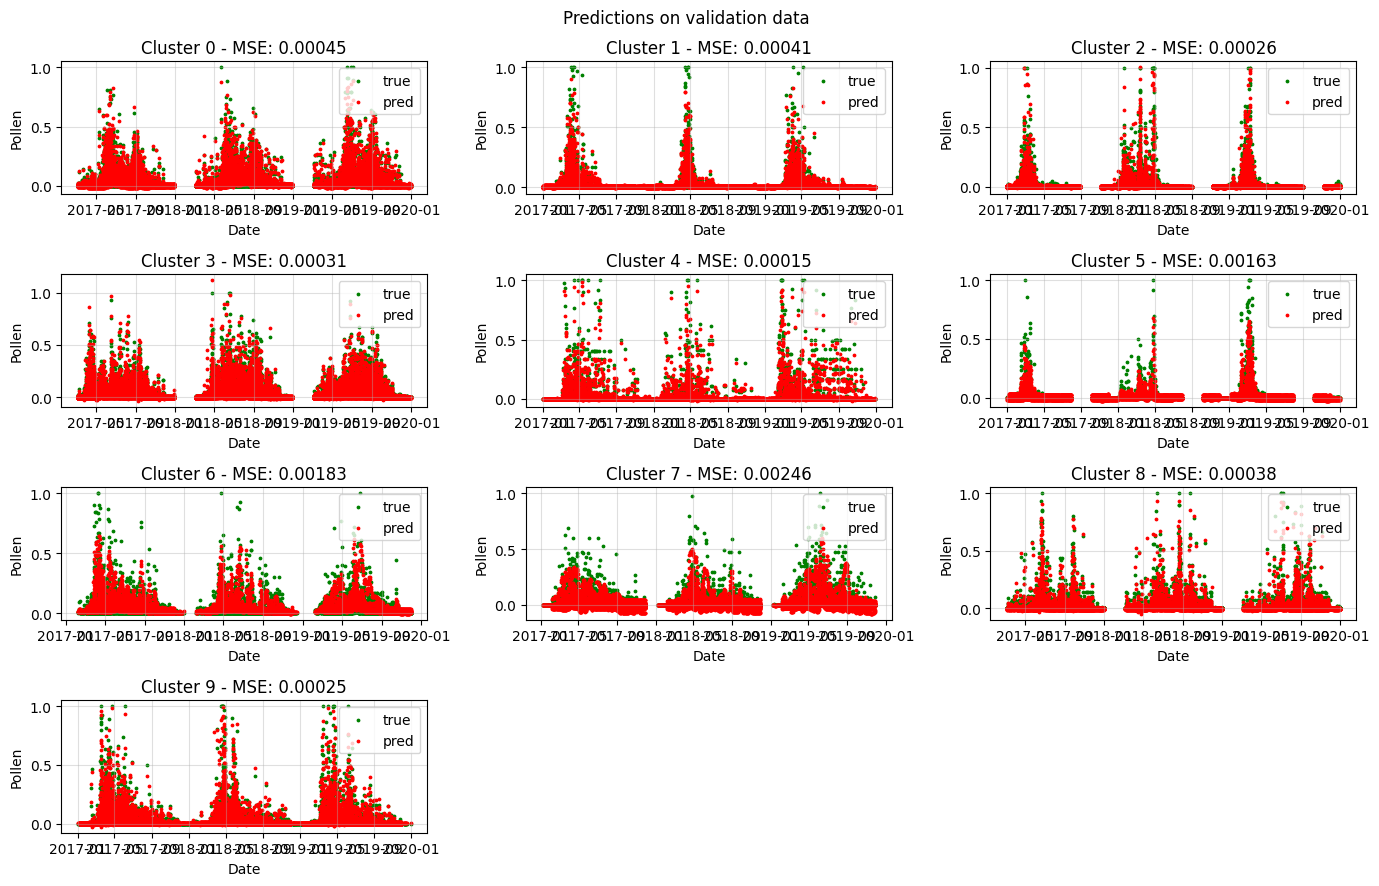

In [18]:
### Test on validation data
rows, cols = 4, 3
fig, axs = plt.subplots(rows, cols, figsize=(14,9), squeeze=False)
plt.suptitle("Predictions on validation data")
for subpltn, dataset in enumerate(trainings):
    predictions = dataset.model.predict(dataset.valid_dataset, verbose=False).squeeze()
    mse = dataset.model.evaluate(dataset.valid_dataset, verbose=False)
    ax = axs[divmod(subpltn, cols)]
    ax.set_title(f"Cluster {dataset.cluster_n} - MSE: {np.round(mse, 5)}")
    ax.scatter(dataset.y_valid.index, dataset.y_valid.values, s=3, c="green", label="true")
    ax.scatter(dataset.y_valid.index[:-model_params.sequence_length+1], predictions, s=3, c="red", label="pred")
    ax.set_ylabel("Pollen")
    ax.set_xlabel("Date")
    ax.legend(loc="upper right")
    ax.grid(alpha=0.4)

for subpltn in range(subpltn + 1, rows * cols): fig.delaxes(axs.flatten()[subpltn])  # removing empty plots from subplot grid
plt.tight_layout()
plt.show();

# 6. Test set - Performances per cluster
* These results are referring to test data, which the model has not been trained nor validated on.

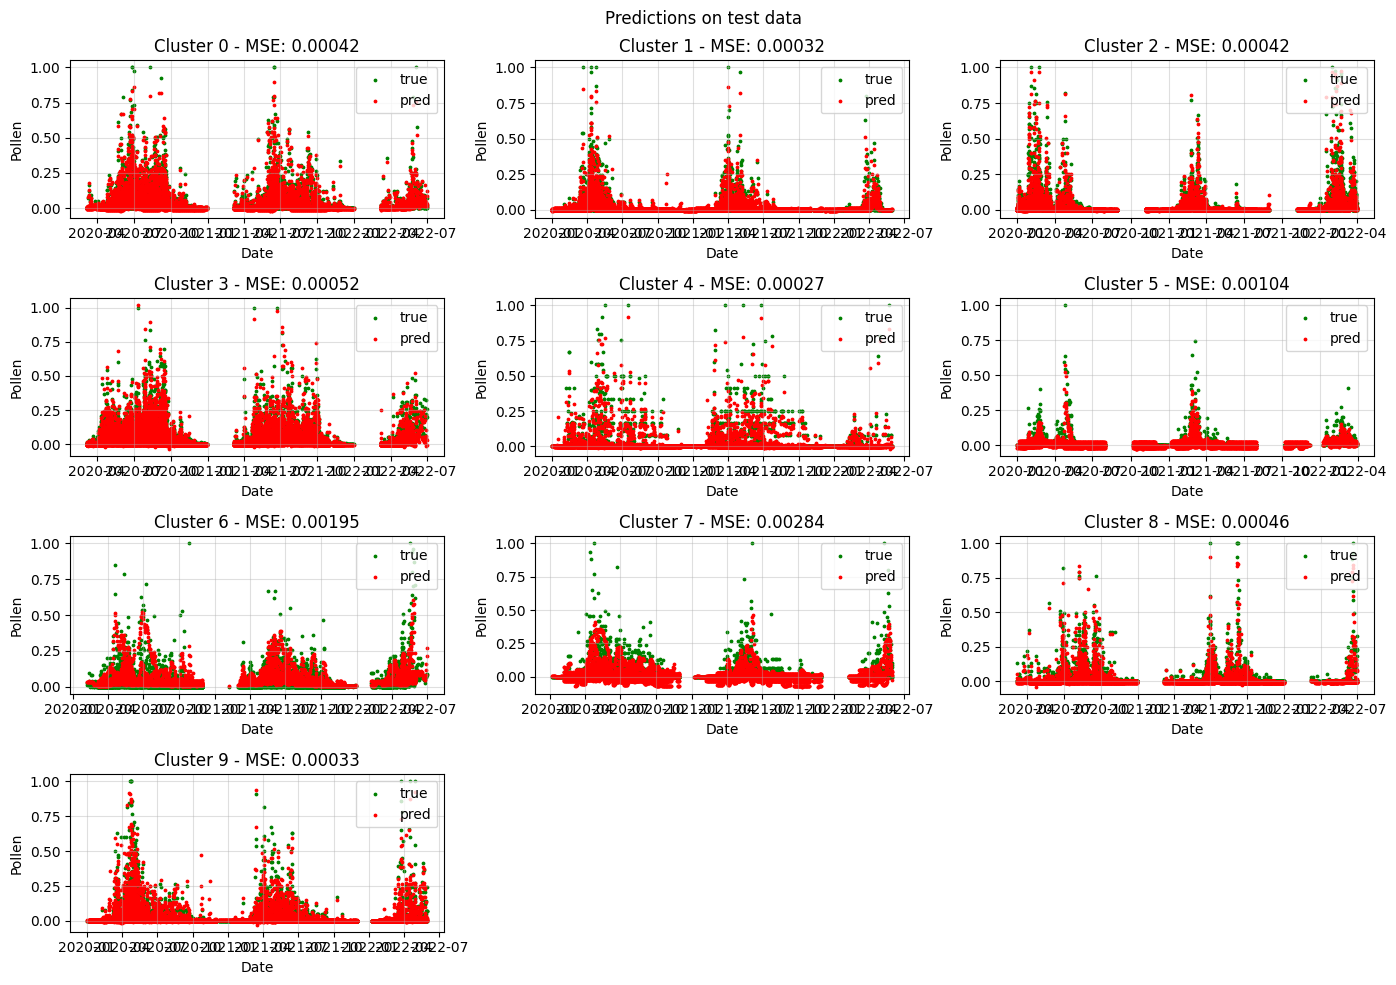

In [19]:
### Test on test data
rows, cols = 4, 3
fig, axs = plt.subplots(rows, cols, figsize=(14,10), squeeze=False)
plt.suptitle("Predictions on test data")
for subpltn, dataset in enumerate(trainings):
    predictions = dataset.model.predict(dataset.test_dataset, verbose=False).squeeze()
    mse = dataset.model.evaluate(dataset.test_dataset, verbose=False)
    ax = axs[divmod(subpltn, cols)]
    ax.set_title(f"Cluster {dataset.cluster_n} - MSE: {np.round(mse, 5)}")
    ax.scatter(dataset.y_test.index, dataset.y_test.values, s=3, c="green", label="true")
    ax.scatter(dataset.y_test.index[:-model_params.sequence_length+1], predictions, s=3, c="red", label="pred")
    ax.set_ylabel("Pollen")
    ax.set_xlabel("Date")
    ax.legend(loc="upper right")
    ax.grid(alpha=.4)

for subpltn in range(subpltn+1, rows*cols): fig.delaxes(axs.flatten()[subpltn]) # removing empty plots from subplot grid
plt.tight_layout()
plt.show();

# 7. Test set - Predictions visualization

In [20]:
cluster_wgt = _create_cluster_n_widget(clusters)
display(cluster_wgt)

Dropdown(description='Cluster id:', layout=Layout(width='50%'), options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=…

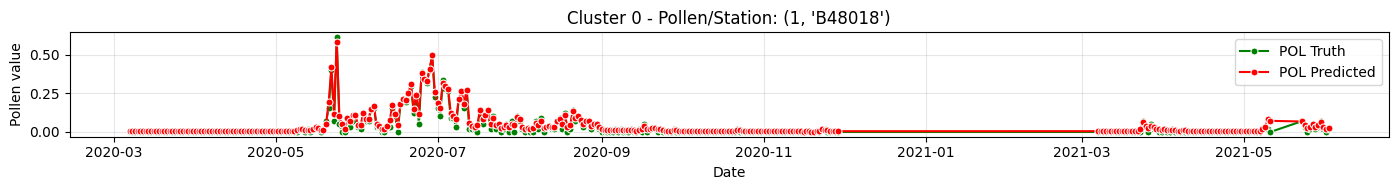

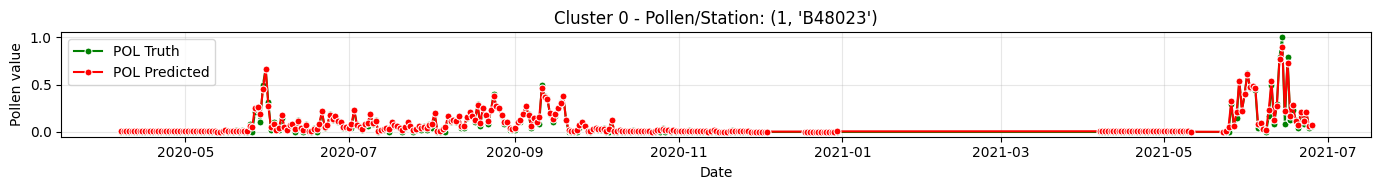

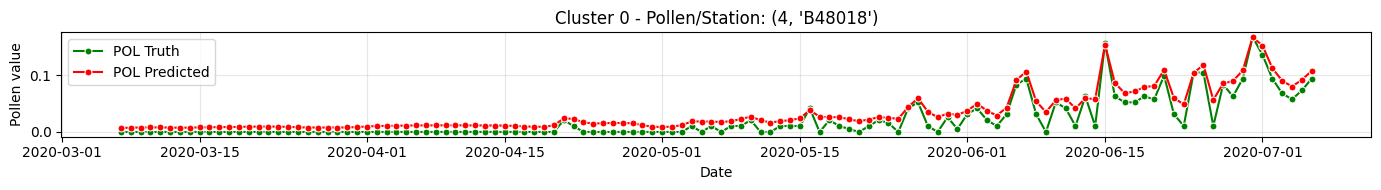

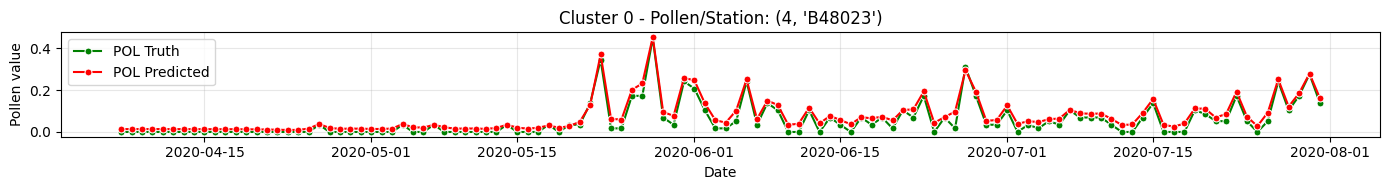

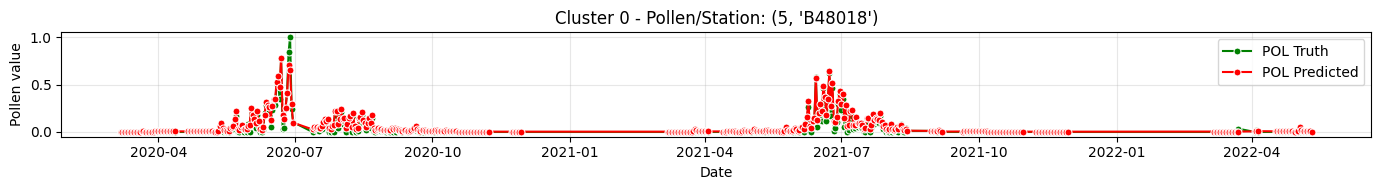

In [21]:
### Cluster specie/pollen prediction
specie_pollen_dataset = list(filter(lambda d: d.cluster_n == cluster_wgt.value, trainings))[0]

mses = []
for plotn, (group_idx, specie_group) in enumerate(specie_pollen_dataset.x_test.groupby(["station_id", "pol_var_id"])):
    if plotn >= 5: break
    species_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(specie_group[specie_pollen_dataset.features], targets=None, sequence_length=model_params.sequence_length, batch_size=model_params.batch_size)
    specie_group = specie_group[:-model_params.sequence_length+1]
    predictions = specie_pollen_dataset.model.predict(species_dataset, verbose=False).squeeze()
    mse = specie_pollen_dataset.model.evaluate(species_dataset, verbose=False)
    mses.append(mse)

    plt.figure(figsize=(14, 2))
    plt.title(f"Cluster {specie_pollen_dataset.cluster_n} - Pollen/Station: {group_idx}")
    sns.lineplot(x=specie_group.index, y=specie_group.pol_value_label, marker="o", markersize=5, label="POL Truth", c="green")
    sns.lineplot(x=specie_group.index, y=predictions, marker="o", markersize=5, label="POL Predicted", c="red")
    plt.xlabel("Date")
    plt.ylabel("Pollen value")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# 8. Test set - Single specie

In [22]:
specie_wgt = _create_pol_var_id_widget(clusters)
display(specie_wgt)

Dropdown(description='Pol var id:', layout=Layout(width='50%'), options=('B48001', 'B48002', 'B48003', 'B48005…

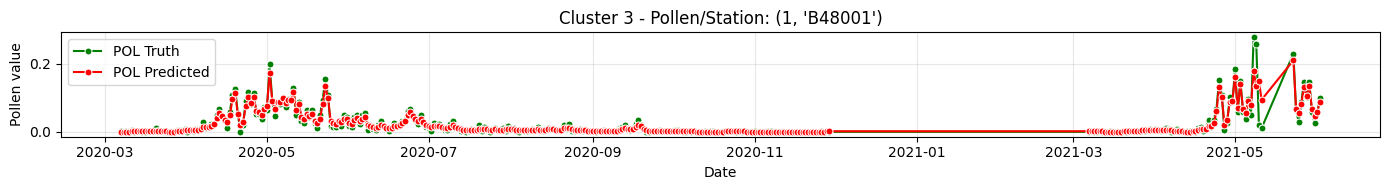

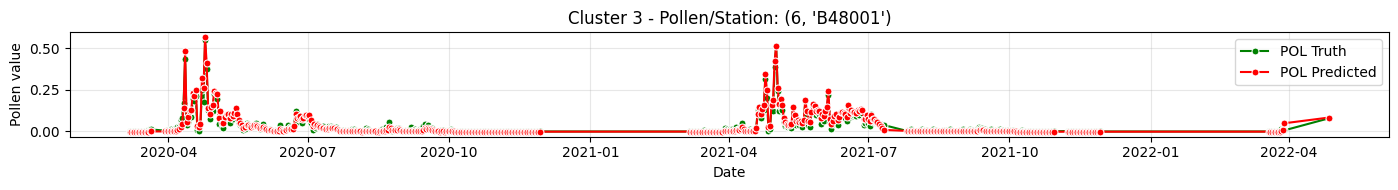

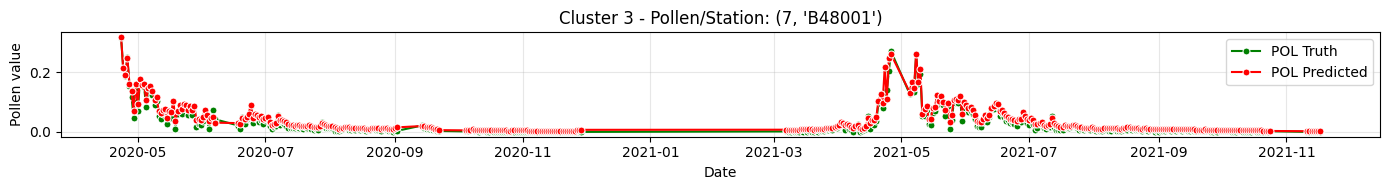

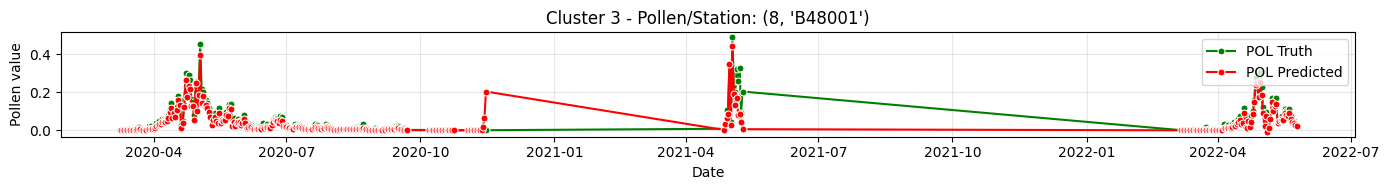

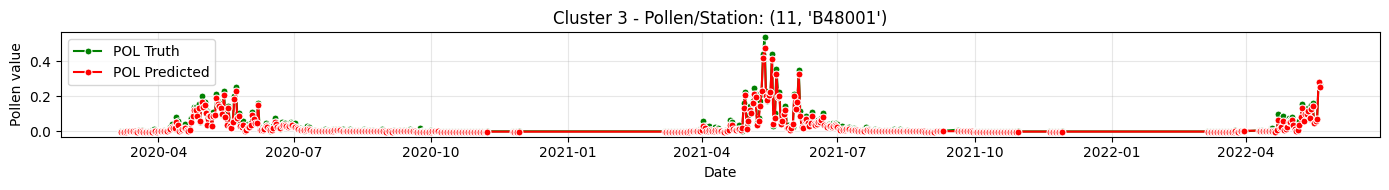

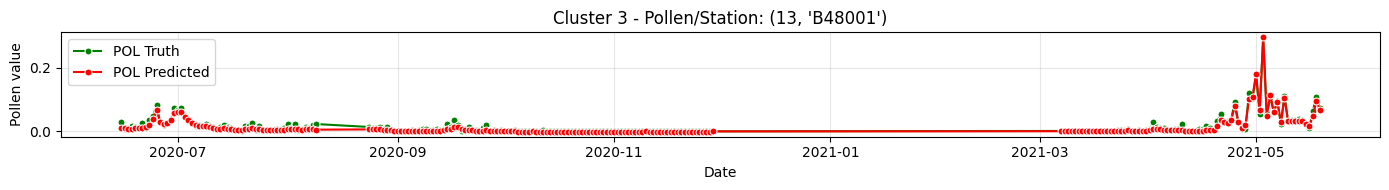

In [23]:
### Cluster specie/pollen prediction
specie_clst = clusters[clusters.pol_var_id == specie_wgt.value].cluster.iloc[0]
specie_pollen_dataset = list(filter(lambda d: d.cluster_n == specie_clst, trainings))[0]
specie_pollen_data = specie_pollen_dataset.x_test
specie_pollen_data = specie_pollen_data[specie_pollen_data.pol_var_id == specie_wgt.value]

for group_idx, specie_group in specie_pollen_data.groupby(["station_id", "pol_var_id"]):
    species_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
        specie_group[specie_pollen_dataset.features],
        targets=None,
        sequence_length=model_params.sequence_length,
        batch_size=model_params.batch_size,
    )
    specie_group = specie_group[:-model_params.sequence_length+1]

    predictions = specie_pollen_dataset.model.predict(species_dataset, verbose=False).squeeze()
    mse = specie_pollen_dataset.model.evaluate(species_dataset, verbose=False)

    plt.figure(figsize=(14, 2))
    plt.title(f"Cluster {specie_pollen_dataset.cluster_n} - Pollen/Station: {group_idx}")
    sns.lineplot(x=specie_group.index, y=specie_group.pol_value_label, marker="o", markersize=5, label="POL Truth", c="green")
    sns.lineplot(x=specie_group.index, y=predictions, marker="o", markersize=5, label="POL Predicted", c="red")
    plt.xlabel("Date")
    plt.ylabel("Pollen value")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    tf.keras.backend.clear_session()

# 9. Performance scores per Cluster / Station / Specie

In [24]:
test_scores = []
print("Model:", model_name)
for dataset in tqdm(trainings):
    for (station_id, specie_id), specie_data in dataset.x_test.groupby(["station_id", "pol_var_id"]):
        if len(specie_data) < 7: continue

        species_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(specie_data[dataset.features], targets=specie_data.pol_value_label, sequence_length=model_params.sequence_length, batch_size=model_params.batch_size)
        mse = dataset.model.evaluate(species_dataset, verbose=False)
        y_pred = dataset.model.predict(species_dataset, verbose=False).squeeze()

        test_scores.append({
            "cluster_n": dataset.cluster_n,
            "station_id": station_id,
            "specie_id": specie_id,
            "mse": mse,
            "y_true": specie_data.pol_value_label.values[model_params.sequence_length-1:],
            "y_pred": y_pred
        })

test_scores = pd.DataFrame(test_scores)
test_scores.head()

Model: LSTM+MultiHeadAttention+AdamW


  0%|          | 0/10 [00:00<?, ?it/s]

,cluster_n,station_id,specie_id,mse,y_true,y_pred
0,0,1,B48018,0.000235,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0039368384, 0.004223807, 0.00449669, 0.0048..."
1,0,1,B48023,0.000387,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0074290466, 0.0074568912, 0.007493064, 0.00..."
2,0,4,B48018,0.000236,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0069906805, 0.007493592, 0.007821226, 0.008..."
3,0,4,B48023,0.000606,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.013748601, 0.013782971, 0.013857126, 0.0138..."
4,0,5,B48018,0.000883,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00241719, 0.0027157366, 0.0030242205, 0.003..."


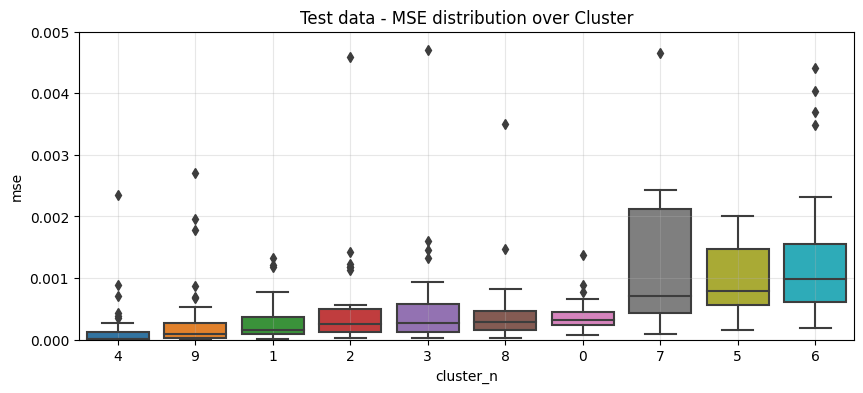

In [25]:
### MSE distribution over clusters
sort_idx = test_scores.groupby("cluster_n")["mse"].median().reset_index().sort_values("mse")
plt.figure(figsize=(10,4))
plt.title("Test data - MSE distribution over Cluster")
sns.boxplot(data=test_scores, x="cluster_n", y="mse", order=sort_idx["cluster_n"])
plt.grid(alpha=.3);
plt.ylim(0, 0.005);

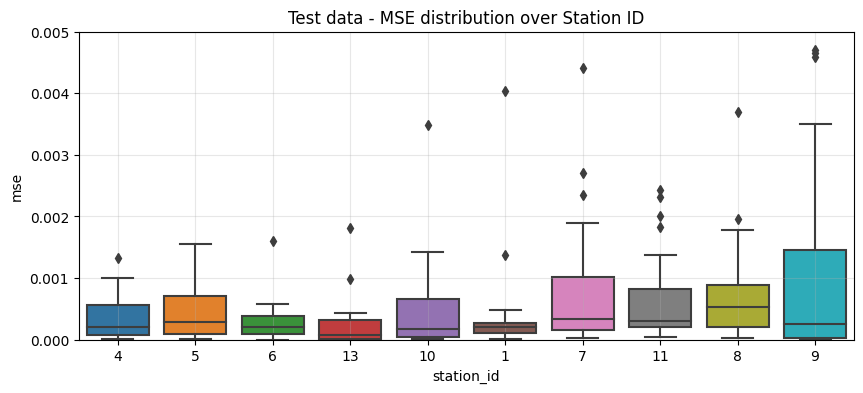

In [26]:
### MSE distribution over Stations, regardless of the cluster
sort_idx = test_scores.groupby("station_id")["mse"].max().reset_index().sort_values("mse")

plt.figure(figsize=(10,4))
plt.title("Test data - MSE distribution over Station ID")
sns.boxplot(data=test_scores, x="station_id", y="mse", order=sort_idx["station_id"])
plt.grid(alpha=.3);
plt.ylim(0, 0.005);

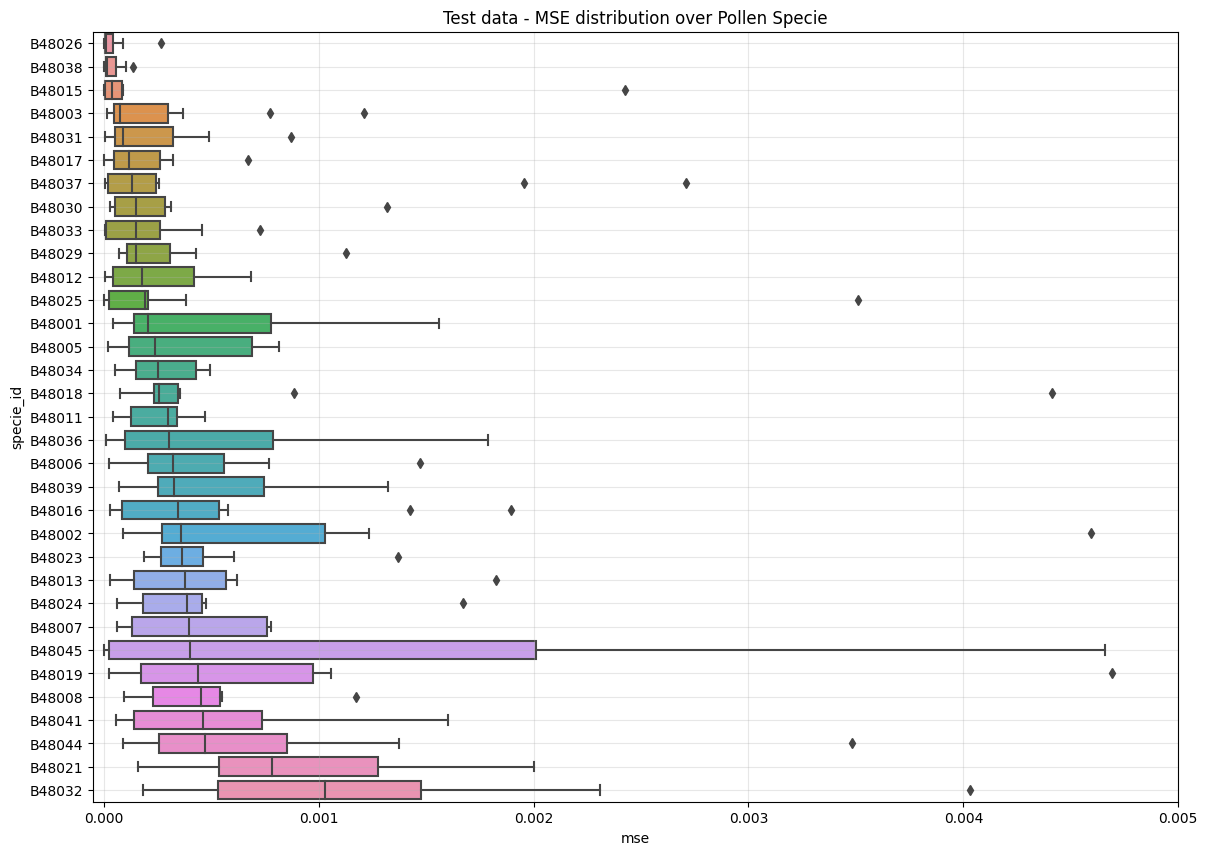

In [27]:
### MSE distribution over Species, regardless of station/cluster
sort_idx = test_scores.groupby("specie_id")["mse"].median().reset_index().sort_values("mse")

plt.figure(figsize=(14, 10))
plt.title("Test data - MSE distribution over Pollen Specie")
sns.boxplot(data=test_scores, x="mse", y="specie_id", order=sort_idx["specie_id"])
plt.grid(alpha=.3);
plt.xlim(-.00005, 0.005);

# 10. Performance score ranges per specie/cluster

Given the target value $t$ and the predicted value $p$, the absolute error is calculated as the absolute difference between the target and predicted values, i.e.,

$Error = |t - p|$

To evaluate the distribution of the error, we can group the errors into a number of bins. For instance, we can divide the error range into 10 equally sized bins. The count or percentage of the error falling within each bin can provide us insights into the model's performance across different levels of errors.

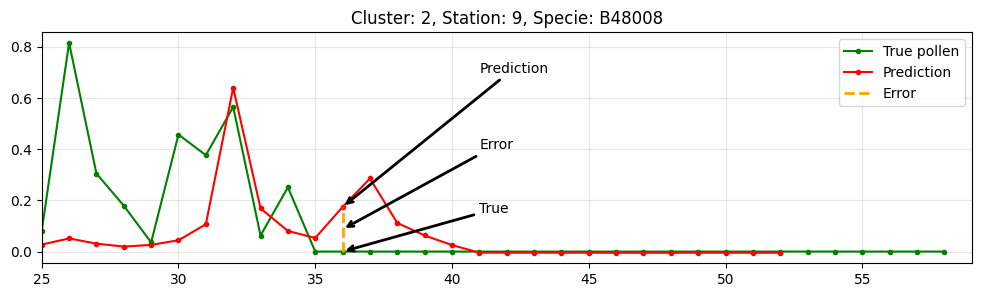

In [28]:
### Explication plot
# sample = test_scores[test_scores.apply(lambda d: d.y_true.std() > .17, axis=1)].sample(1).iloc[0]
sample = test_scores[(test_scores.cluster_n == 2) & (test_scores.station_id == 9) & (test_scores.specie_id == "B48008")].iloc[0]
arrow_idx = 36
pred, true = sample.y_pred[arrow_idx], sample.y_true[arrow_idx]

fig, ax = plt.subplots(figsize=(12, 3))
ax.set_title(f"Cluster: {sample.cluster_n}, Station: {sample.station_id}, Specie: {sample.specie_id}")

# Plot pollen true value and prediction
ax.plot(sample.y_true, ".-", c="green", label="True pollen")
ax.plot(sample.y_pred[:-model_params.sequence_length+1], ".-", c="red", label="Prediction")

ax.annotate("True", xy=(arrow_idx, true), xytext=(arrow_idx+5, .15), arrowprops=dict(lw=2, arrowstyle="->"))
ax.annotate("Prediction", xy=(arrow_idx, pred), xytext=(arrow_idx+5, .7), arrowprops=dict(lw=2, arrowstyle="->"))
ax.annotate("Error", xy=(arrow_idx, abs(true-pred)/2), xytext=(arrow_idx+5, .4), arrowprops=dict(lw=2, arrowstyle="->"))
ax.vlines(x=arrow_idx, colors="orange", lw=2, linestyles="dashed", label="Error", ymin=min(true, pred), ymax=max(true, pred))
ax.grid(alpha=.3)
plt.xlim(25, len(sample.y_true))
ax.legend(loc="upper right")
plt.show()

## 10.1 Error distribution per station/pollen

Ditribution of True/Prediction errors in bins


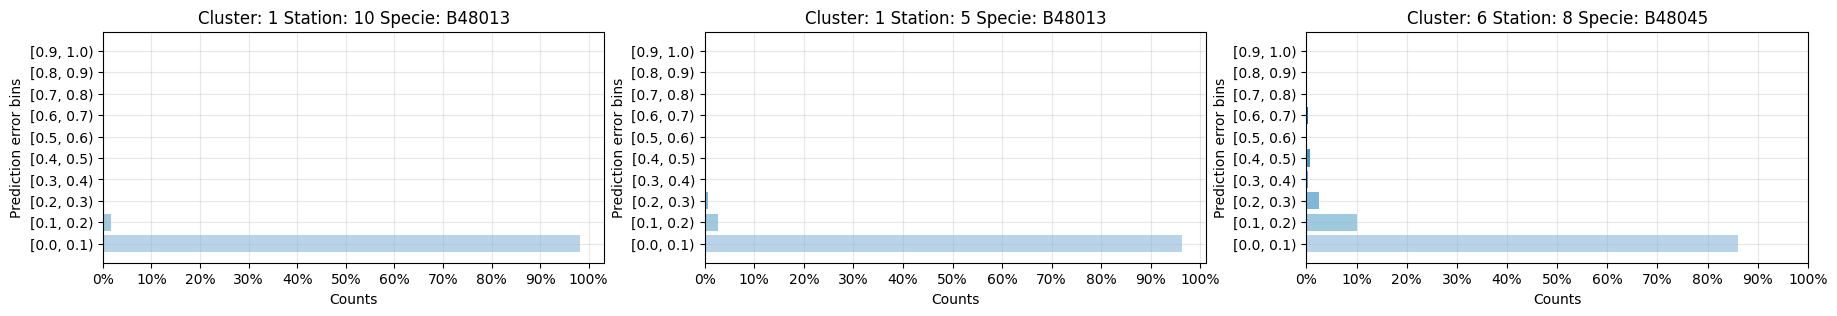

In [29]:
rows, cols = 1, 3
fig, axs = plt.subplots(rows, cols, figsize=(22,3), squeeze=False)
print("Ditribution of True/Prediction errors in bins")
for subpltn, (_, entry) in enumerate(test_scores.sample(cols).iterrows()):
    # Evaluate True/prediction abs diff
    score_error = np.abs(entry.y_true - entry.y_pred)
    edges = np.histogram_bin_edges(score_error, bins=10, range=(0, 1))
    counts, _ = np.histogram(score_error, bins=edges)
    counts = (counts / sum(counts)) * 100 # Normalize
    
    ax = axs[divmod(subpltn, cols)]
    ax.set_title(f"Cluster: {entry.cluster_n} Station: {entry.station_id} Specie: {entry.specie_id}")
    colors = plt.cm.Blues(np.linspace(0.3, 1, len(counts)))
    ax.barh(np.arange(len(counts)), counts, color=colors)

    yticklabels = [f"[{edges[i]:.1f}, {edges[i+1]:.1f})" for i in range(len(edges)-1)]
    ax.set_yticks(np.arange(len(yticklabels)))
    ax.set_yticklabels(yticklabels)
    ax.set_xticks(np.arange(0, 101, 10), labels=[f"{int(tick)}%" for tick in np.arange(0, 101, 10)])

    ax.set_xlabel("Counts")
    ax.set_ylabel("Prediction error bins")
    ax.grid(alpha=.3)

plt.show()

## 10.2 Error distribution for all clusters

All clusters True/Prediction error distribution in bins
Error in bin [0.0, 0.1) with perc: 93.89%
Error in bin [0.1, 0.2) with perc:   3.8%
Error in bin [0.2, 0.3) with perc:  1.23%
Error in bin [0.3, 0.4) with perc:   0.5%
Error in bin [0.4, 0.5) with perc:  0.27%
Error in bin [0.5, 0.6) with perc:  0.14%
Error in bin [0.6, 0.7) with perc:  0.07%
Error in bin [0.7, 0.8) with perc:  0.05%
Error in bin [0.8, 0.9) with perc:  0.03%
Error in bin [0.9, 1.0) with perc:  0.02%


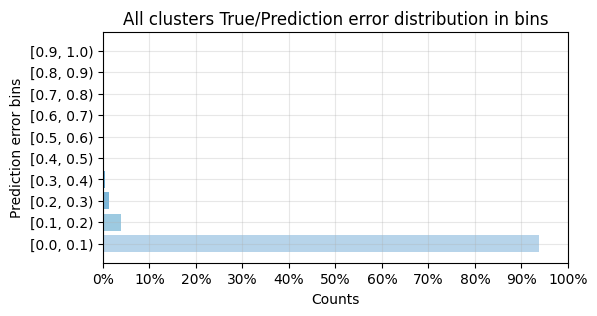

In [30]:
all_score_err = None
for _, entry in test_scores.iterrows():
    # Evaluate True/prediction abs diff
    score_error = np.abs(entry.y_true - entry.y_pred)
    # Count values in ranges and normalize
    counts, _ = np.histogram(score_error, bins=edges)
    all_score_err = all_score_err + counts if all_score_err is not None else counts
all_score_err = (all_score_err / sum(all_score_err)) * 100

edges = np.histogram_bin_edges(all_score_err, bins=10, range=(0, 1))
range_labels = [f"[{edges[i]:.1f}, {edges[i+1]:.1f})" for i in range(len(edges)-1)]

print("All clusters True/Prediction error distribution in bins")
all_score_bins = list(zip(range_labels, all_score_err.round(2)))
for bin_range, bin_perc in all_score_bins:
    print(f"Error in bin {bin_range} with perc: {str(bin_perc).rjust(5)}%")

fig, ax = plt.subplots(figsize=(6, 3))
plt.title("All clusters True/Prediction error distribution in bins")
colors = plt.cm.Blues(np.linspace(0.3, 1, len(all_score_err)))
ax.barh(np.arange(len(all_score_err)), all_score_err, color=colors)
ax.set_yticks(np.arange(len(range_labels)))
ax.set_yticklabels(range_labels)
ax.set_xticks(np.arange(0, 101, 10), labels=[f"{int(tick)}%" for tick in np.arange(0, 101, 10)])
ax.set_xlabel("Counts")
ax.set_ylabel("Prediction error bins")
ax.grid(alpha=.3)
plt.show()

# 11. Error on pollen ranges

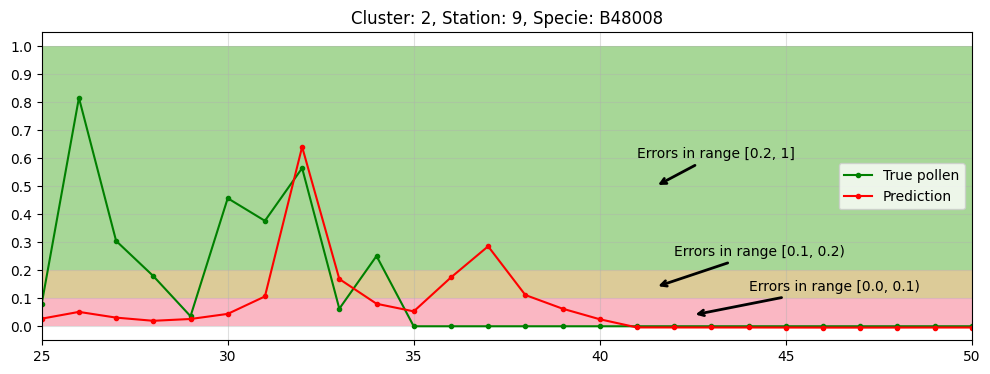

In [31]:
### Explication plot
sample = test_scores[(test_scores.cluster_n == 2) & (test_scores.station_id == 9) & (test_scores.specie_id == "B48008")].iloc[0]
arrow_idx = 41
pred, true = sample.y_pred[arrow_idx], sample.y_true[arrow_idx]

fig, ax = plt.subplots(figsize=(12, 4))
ax.set_title(f"Cluster: {sample.cluster_n}, Station: {sample.station_id}, Specie: {sample.specie_id}")

# Plot pollen true value and prediction
ax.plot(sample.y_true, ".-", c="green", label="True pollen")
ax.plot(sample.y_pred[:-model_params.sequence_length+1], ".-", c="red", label="Prediction")

bin_colors = sns.color_palette("husl", 6)
ax.axhspan(.0, .1, facecolor=bin_colors[0], alpha=.5)
ax.annotate(f"Errors in range {range_labels[0]}", xy=(arrow_idx+1.5, .1-.06), xytext=(arrow_idx+3, .125), arrowprops=dict(lw=2, arrowstyle="->"))

ax.axhspan(.1, .2, facecolor=bin_colors[1], alpha=.5)
ax.annotate(f"Errors in range {range_labels[1]}", xy=(arrow_idx+.5, .2-.06), xytext=(arrow_idx+1, .25), arrowprops=dict(lw=2, arrowstyle="->"))

ax.axhspan(.2, 1., facecolor=bin_colors[2], alpha=.5)
ax.annotate("Errors in range [0.2, 1]", xy=(arrow_idx+.5, .5), xytext=(arrow_idx, .6), arrowprops=dict(lw=2, arrowstyle="->"))

ax.set_yticks(np.arange(0, 1.1, .1))
ax.grid(alpha=.4)
ax.legend(loc="center right")
plt.ylim(-.05, 1.05)
plt.xlim(25, 50)

plt.show()

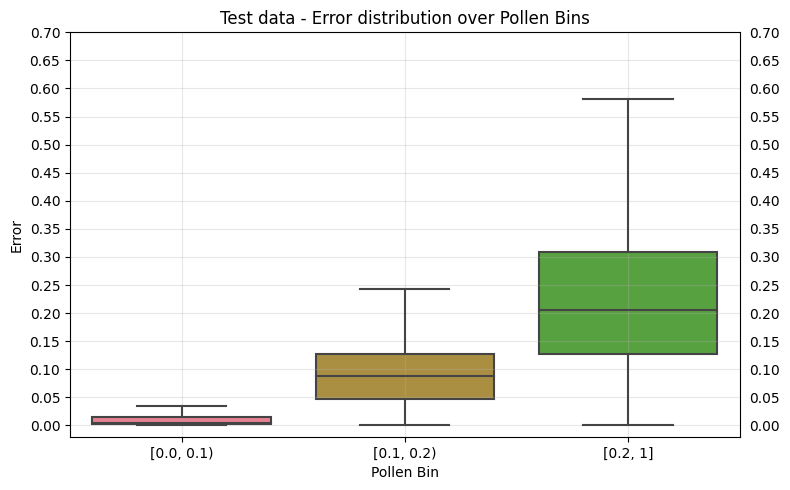

In [32]:
def get_bin(x):
    if x < .1: return 0
    if x < .2: return 1
    return 2

test_scores_df = test_scores.explode(["y_true", "y_pred"])
test_scores_df["error"] = np.abs(test_scores_df.y_true - test_scores_df.y_pred)
test_scores_df["true_bin"] = test_scores_df.y_true.apply(get_bin)

plt.figure(figsize=(8, 5))
plt.title("Test data - Error distribution over Pollen Bins")
sns.boxplot(data=test_scores_df, x="true_bin", y="error", palette=bin_colors, showfliers=False)
plt.xticks([0, 1, 2], [range_labels[0], range_labels[1], "[0.2, 1]"])
plt.yticks(np.arange(0, 1, .05))
plt.xlabel("Pollen Bin")
plt.ylabel("Error")
plt.ylim(-.02, .7)
plt.tick_params(axis='y', which='both', labelleft='on', labelright='on')
plt.grid(alpha=.3)
plt.tight_layout()

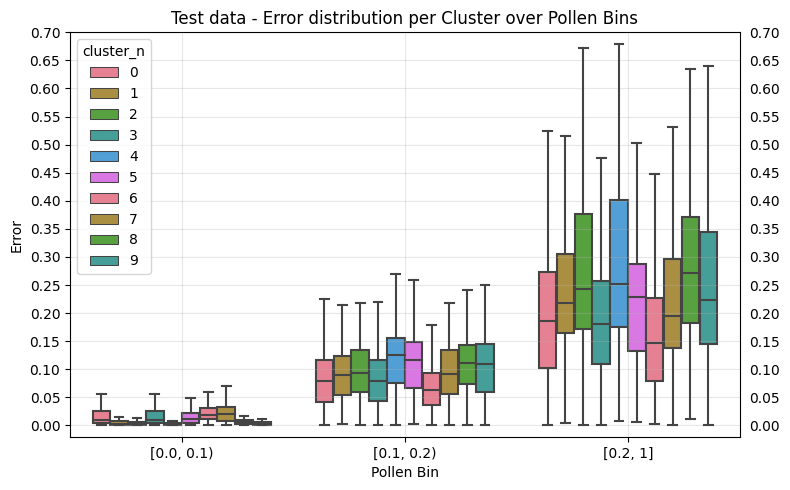

In [33]:
plt.figure(figsize=(8, 5))
plt.title("Test data - Error distribution per Cluster over Pollen Bins")
sns.boxplot(data=test_scores_df, x="true_bin", y="error", hue="cluster_n", palette=bin_colors, showfliers=False)
plt.xticks([0, 1, 2], [range_labels[0], range_labels[1], "[0.2, 1]"])
plt.yticks(np.arange(0, 1, .05))
plt.xlabel("Pollen Bin")
plt.ylabel("Error")
plt.ylim(-.02, .7)
plt.tick_params(axis='y', which='both', labelleft='on', labelright='on')
plt.grid(alpha=.3)
plt.tight_layout()

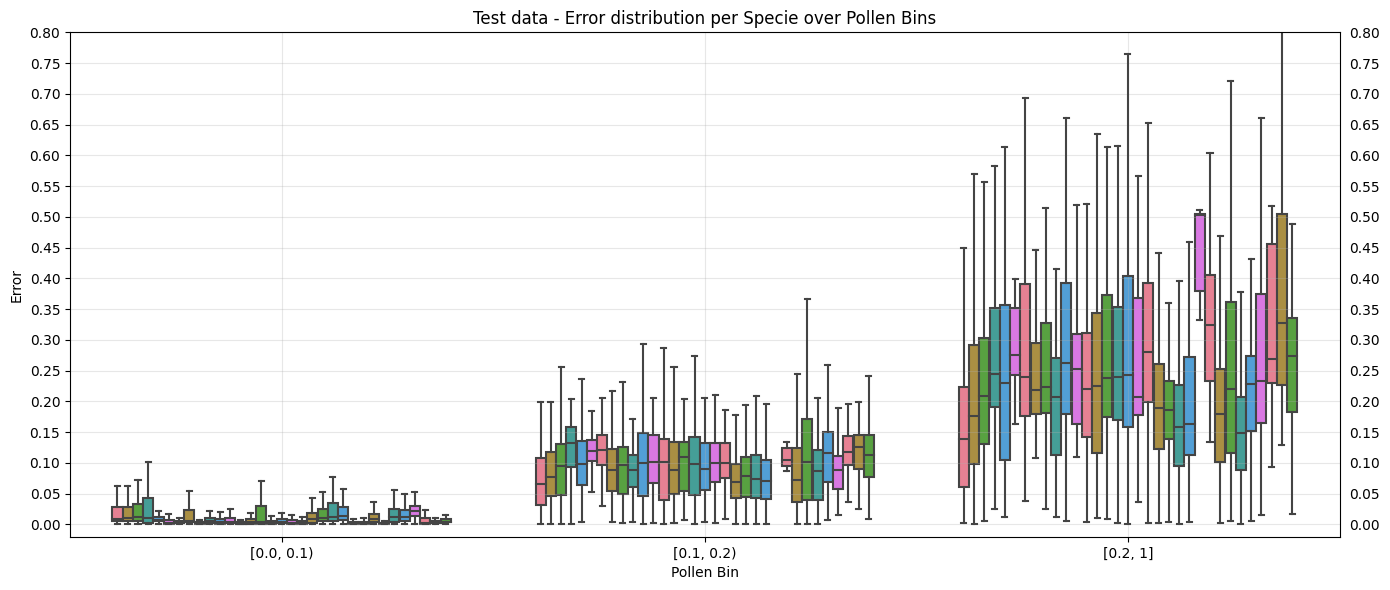

In [34]:
plt.figure(figsize=(14, 6))
plt.title("Test data - Error distribution per Specie over Pollen Bins")
sns.boxplot(data=test_scores_df, x="true_bin", y="error", hue="specie_id", palette=bin_colors, showfliers=False)
plt.xticks([0, 1, 2], [range_labels[0], range_labels[1], "[0.2, 1]"])
plt.yticks(np.arange(0, 1, .05))
plt.xlabel("Pollen Bin")
plt.ylabel("Error")
plt.ylim(-.02, .8)
plt.tick_params(axis='y', which='both', labelleft='on', labelright='on')
plt.grid(alpha=.3)
plt.legend('', frameon=False)
plt.tight_layout()

___

# 12. Continuous prediction
* Starting from day-0, we are using the predicted pollen as input feature of the next day
* This gives us a great "goodness" of the trained model

In [35]:
pol_prev_columns = ['pol_value_prev_1', 'pol_value_prev_2', 'pol_value_prev_3', 'pol_value_prev_4', 'pol_value_prev_5', 'pol_value_prev_6', 'pol_value_prev_7']

In [36]:
load_from_file = True

if load_from_file:
    test_scores = pd.read_feather("data/test_scores.feather")
else:
    test_scores["y_continuous_pred"] = None
    for row_idx, row in tqdm(test_scores.iterrows(), total=len(test_scores)):

        # Select data
        dataset = list(filter(lambda t: t.cluster_n == row.cluster_n, trainings))[0]
        specie_data = dataset.x_test[(dataset.x_test.station_id == row.station_id) & (dataset.x_test.pol_var_id == row.specie_id)]
        specie_data = specie_data.copy()

        # Continuous prediction
        y_continuous_preds = []
        for window in tqdm(specie_data.rolling(model_params.sequence_length), total=len(specie_data), leave=False):
            if len(window) < model_params.sequence_length: continue

            X = window[dataset.features]

            # Set previous pollen values from prediction instead of original dataset
            if len(y_continuous_preds) > 12: # ensuring we have enough values
                for prev_n in range(model_params.sequence_length):
                    prev_pollen_preds = y_continuous_preds[ -model_params.sequence_length-prev_n : -prev_n if prev_n else None]    
                    X[ pol_prev_columns[prev_n] ] = prev_pollen_preds

            X_ts = tf.keras.preprocessing.timeseries_dataset_from_array(X, targets=None, sequence_length=model_params.sequence_length, batch_size=1)
            y_continuous_pred = dataset.model.predict(X_ts, verbose=False).squeeze()
            y_continuous_preds.append(float(y_continuous_pred))

        test_scores.at[row_idx, "y_continuous_pred"] = y_continuous_preds
    # Store results to feather
    test_scores.to_feather("data/test_scores.feather")

test_scores.head(3)

,cluster_n,station_id,specie_id,mse,y_true,y_pred,y_continuous_pred
0,0,1,B48018,0.000287,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.007995423, -0.0078028254, -0.0074707605, -...","[-0.007993336766958237, -0.007808748632669449,..."
1,0,1,B48023,0.000862,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.00943993, -0.00931453, -0.009352736, -0.00...","[-0.009441342204809189, -0.009319756180047989,..."
2,0,4,B48018,0.000274,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.0094490945, -0.009308357, -0.0095211975, -...","[-0.009452413767576218, -0.00931556150317192, ..."


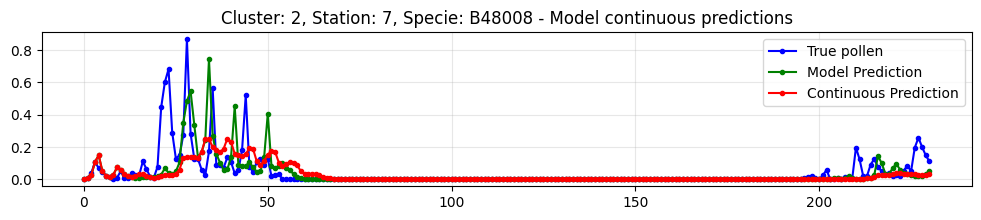

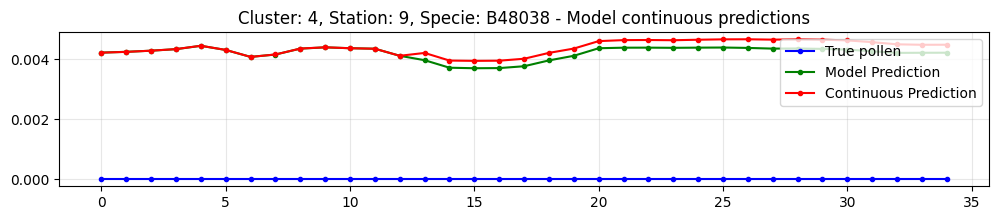

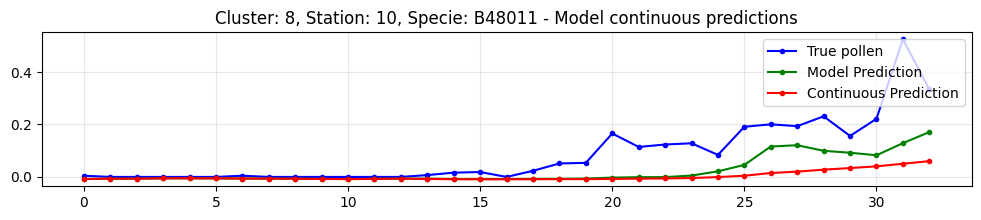

In [37]:
for _, row in test_scores.sample(3).iterrows():

    plt.figure(figsize=(12, 2))
    plt.title(f"Cluster: {row.cluster_n}, Station: {row.station_id}, Specie: {row.specie_id} - Model continuous predictions")
    plt.plot(row.y_true, ".-", c="blue", label="True pollen")
    plt.plot(row.y_pred, ".-", c="green", label="Model Prediction")
    plt.plot(row.y_continuous_pred, ".-", c="red", label="Continuous Prediction")
    plt.grid(alpha=.3)
    plt.legend(loc="upper right")
    plt.show()

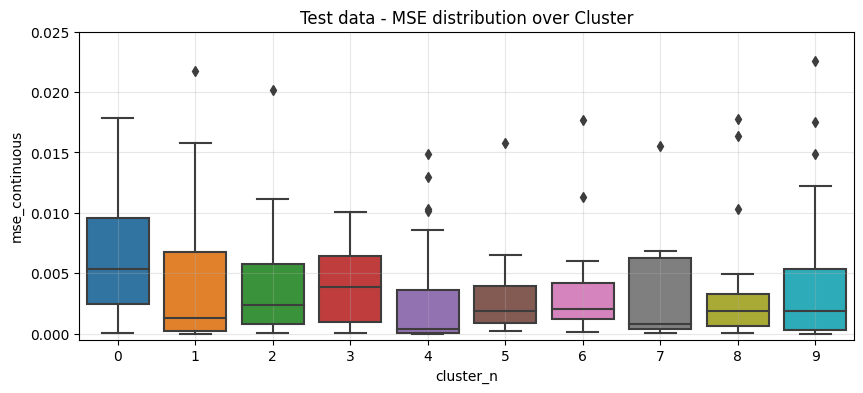

In [38]:
test_scores["mse_continuous"] = test_scores.apply(lambda r: np.square(np.subtract(r.y_true, r.y_continuous_pred)).mean(), axis=1)

### Sort by mean, for plotting purpose
sort_idx = test_scores.groupby("cluster_n")["mse_continuous"].max().reset_index().sort_values("mse_continuous")
plt.figure(figsize=(10,4))
plt.title("Test data - MSE distribution over Cluster")
sns.boxplot(data=test_scores, x="cluster_n", y="mse_continuous")#, order=sort_idx["cluster_n"])
plt.grid(alpha=.3);
plt.ylim(-.0005, 0.025);